In [1]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

try: import timm
except ModuleNotFoundError:
    !pip install -Uq "timm==0.6.2.dev0"

try: import tensorflow
except ModuleNotFoundError:
    !pip install -Uq tensorflow

try: import torcheval
except ModuleNotFoundError:
    !pip install -Uq torcheval

try: import huggingface_hub
except ModuleNotFoundError:
    !pip install -Uq huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.9/497.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.5 MB/s eta 0:00:00


In [2]:
from fastkaggle import *

In [3]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not iskaggle and not cred_path.exists():
    creds = '{"username":"alexchalk","key":"4320b3bb98c3460501e0eb8393828540"}'
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
comp = 'tpu-getting-started'

path = setup_comp(comp, install='fastai tensorflow "timm==0.6.2.dev0"')
classes = ["pink primrose","hard-leaved pocket orchid","canterbury bells","sweet pea","wild geranium","tiger lily","moon orchid","bird of paradise","monkshood","globe thistle","snapdragon","colt's foot","king protea","spear thistle","yellow iris","globe-flower","purple coneflower","peruvian lily","balloon flower","giant white arum lily","fire lily","pincushion flower","fritillary","red ginger","grape hyacinth","corn poppy","prince of wales feathers","stemless gentian","artichoke","sweet william","carnation","garden phlox","love in the mist","cosmos","alpine sea holly","ruby-lipped cattleya","cape flower","great masterwort","siam tulip","lenten rose","barberton daisy","daffodil","sword lily","poinsettia","bolero deep blue","wallflower","marigold","buttercup","daisy","common dandelion","petunia","wild pansy","primula","sunflower","lilac hibiscus","bishop of llandaff","gaura","geranium","orange dahlia","pink-yellow dahlia","cautleya spicata","japanese anemone","black-eyed susan","silverbush","californian poppy","osteospermum","spring crocus","iris","windflower","tree poppy","gazania","azalea","water lily","rose","thorn apple","morning glory","passion flower","lotus","toad lily","anthurium","frangipani","clematis","hibiscus","columbine","desert-rose","tree mallow","magnolia","cyclamen ","watercress","canna lily","hippeastrum ","bee balm","pink quill","foxglove","bougainvillea","camellia","mallow","mexican petunia","bromelia","blanket flower","trumpet creeper","blackberry lily","common tulip","wild rose"]

100%|██████████| 4.79G/4.79G [00:43<00:00, 118MB/s]


In [5]:
path

Path('tpu-getting-started')

In [6]:
import timm
import functools
import itertools
from fastai.vision.all import *

path.ls()

(#5) [Path('tpu-getting-started/tfrecords-jpeg-512x512'),Path('tpu-getting-started/tfrecords-jpeg-224x224'),Path('tpu-getting-started/tfrecords-jpeg-331x331'),Path('tpu-getting-started/tfrecords-jpeg-192x192'),Path('tpu-getting-started/sample_submission.csv')]

In [7]:
data_paths = list(filter(lambda x: str(x) != "tpu-getting-started/sample_submission.csv", path.ls()))
data_paths = [path/'tfrecords-jpeg-224x224']
data_paths = functools.reduce(lambda acc, path: list(itertools.chain(acc, (path/'train').ls(), (path/'val').ls())), data_paths, [])

In [8]:
import tensorflow as tf

# https://www.tensorflow.org/tutorials/load_data/tfrecord#reading_a_tfrecord_file_in_python
def load_tfrecs(data_paths, is_test=False):
    data = []
    raw_dataset = tf.data.TFRecordDataset(data_paths)

    for record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(record.numpy())
        datum = [
            None if is_test else example.features.feature['class'].int64_list.value[0],
            example.features.feature['image'].bytes_list.value[0],
            example.features.feature['id'].bytes_list.value[0],
        ]
        data.append(datum)

    return data

data = load_tfrecs(data_paths)

len(data)

16465

(224, 224)


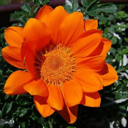

In [9]:
img = PILImage.create(data[0][1])
print(img.size)
img.to_thumb(128)

In [10]:
from fastcore.parallel import *

def f(o): return PILImage.create(o[1]).size
sizes = parallel(f, data, n_workers=8)
pd.Series(sizes).value_counts()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,count
"(224, 224)",16465


In [11]:
def get_items(data, *args, **kwargs): return data

get_x = lambda entry: PILImage.create(io.BytesIO(entry[1]))
get_y = lambda entry: entry[0]

In [ ]:
from torcheval.metrics.functional import multiclass_f1_score
import gc

models = {
    'convnext_large_in22k': 128,
    'vit_large_patch16_224': 224,
    'swinv2_large_window12_192_22k': 192,
    'swin_large_patch4_window7_224': 224,
}

tta_res = []

test_paths = [(path/'tfrecords-jpeg-224x224/test').ls()]
test_data = load_tfrecs(test_paths, is_test=True)

def train(arch, size):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=IndexSplitter(range(12753, len(data))),
                      item_tfms=[],
                      batch_tfms=[*aug_transforms(size=size, min_scale=0.75)])
    dls = block.dataloaders(data, bs=16)

    learn = vision_learner(dls, arch, metrics=multiclass_f1_score, path='.', cbs=GradientAccumulation(64)).to_fp16()
    learn.fine_tune(5, 0.001)

    return learn.tta(dl=dls.test_dl(test_data))

for arch,size in models.items():
      print('---',arch)
      print('---',size)
      tta_res.append(train(arch, size))
      gc.collect()
      torch.cuda.empty_cache()

--- convnext_large_in22k
--- 128


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,multiclass_f1_score,time
0,0.372771,0.190068,0.957974,01:45


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,multiclass_f1_score,time
0,0.158387,0.167044,0.963901,02:39
1,0.195173,0.164374,0.965787,02:37
2,0.107741,0.151529,0.966864,02:36
3,0.073056,0.153783,0.967403,02:36
4,0.050528,0.151707,0.969019,02:34


--- vit_large_patch16_224
--- 224


epoch,train_loss,valid_loss,multiclass_f1_score,time
0,0.445464,0.186988,0.962554,06:12


epoch,train_loss,valid_loss,multiclass_f1_score,time
0,0.155605,0.143448,0.972791,08:06
1,0.131044,0.131936,0.973599,08:04
2,0.094615,0.126581,0.976832,08:02
3,0.066632,0.128350,0.975754,08:01
4,0.027861,0.127531,0.976293,08:01


--- swinv2_large_window12_192_22k
--- 192


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,multiclass_f1_score,time
0,0.325645,0.172591,0.966595,05:46


epoch,train_loss,valid_loss,multiclass_f1_score,time
0,0.198891,0.141914,0.971444,07:02
1,0.188292,0.130506,0.976024,07:01
2,0.091077,0.125399,0.977371,07:01
3,0.030365,0.122111,0.977101,07:01
4,0.059652,0.123257,0.977371,07:01


In [ ]:
tta_prs = first(zip(*tta_res))
avg_pr = torch.stack(tta_prs).mean(0)
avg_pr.shape

In [ ]:
sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission

In [ ]:
# torch.save(learn.model.state_dict(), '03.pth')
# from google.colab import files
# files.download('model_state_dict.pth')
# learn = vision_learner(dls, 'convnext_small_in22k', metrics=multiclass_f1_score, path='.').to_fp16()
# learn.model.load_state_dict(torch.load('01.pth'))

# learn = vision_learner(dls, 'convnext_small_in22k', metrics=multiclass_f1_score, path='.').to_fp16()
# learn.model.load_state_dict(torch.load('01.pth', map_location=torch.device('cpu')))

In [ ]:
idxs = avg_pr.argmax(dim=1)

In [ ]:
idxs

In [ ]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_items,
                    get_x=get_x,
                    get_y=get_y,
                    splitter=IndexSplitter(range(12753, len(data))),
                    item_tfms=[],
                    batch_tfms=[*aug_transforms(size=144, min_scale=0.75)])
dls = block.dataloaders(data, bs=16)
vocab = np.array(dls.vocab)
results = pd.Series(vocab[idxs], name="label")
results

In [ ]:
ids = pd.Series([datum[2].decode('utf-8') for datum in test_data], name="id")
ids

In [ ]:
submission = pd.DataFrame({'id': ids, 'label': results})
submission.to_csv('submission.csv', header=True, index=False)

In [ ]:
!head submission.csv

In [ ]:
# if not iskaggle:
#    from kaggle import api
#    api.competition_submit_cli('submission.csv', 'petals-to-the-metal-01', comp)

In [ ]:
if not iskaggle:
    push_notebook('alexchalk', 'petals-to-the-metal-submission-03',
                  title='Petals to the Metal Submission 03',
                  file='03.ipynb',
                  competition=comp, private=True, gpu=False)